In [1]:
import math
import itertools
import numpy as np
import pandas as pd
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
import skfuzzy as fuzz
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_selection import mutual_info_regression
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

C:\Users\Gonçalo Rosa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# =========================
#   PARÂMETROS EDITÁVEIS
# =========================
# Nº de regras/clusters do ANFIS (TSK) e parâmetro de fuzzificação do FCM global
N_RULES = 3       # <— MUDA AQUI (ex.: 2, 3, 4, ...)
M_FCM = 2.0          # <— fuzzificação (m) típico: 2.0

# Treino híbrido do ANFIS 
ANFIS_MAX_ITERS = 20   # nº de iterações alternando GD (antecedentes) e LS (consequentes)
ANFIS_GD_EPOCHS = 200   # nº de épocas GD por iteração
ANFIS_LR = 1e-4        # taxa de aprendizagem no GD
AGG_PROB = False       # True usa interseção probabilística (norma L2); False ~ min via max(diff)

# Seleção de features (limita explosão de regras nos TS-0/TS-1)
TOP_K_FEATURES = 6     # 2 MFs por feature -> 2^K regras para TS-0/TS-1
SHOW_CLUSTERING_PLOTS = True  # 👈 Muda para False se não quiseres ver os gráficos

In [3]:
# ----------------------------
# 1) Load + preprocess dataset
# ----------------------------


def load_foods_dataset():
    ds = load_dataset("adarshzolekar/foods-nutrition-dataset")
    split_name = "train" if "train" in ds else list(ds.keys())[0]
    df = pd.DataFrame(ds[split_name])

    # Coerce numeric-like strings
    for c in df.columns:
        if df[c].dtype == "object":
            df[c] = pd.to_numeric(df[c], errors="ignore")

    target_col = "Energy kcal"
    if target_col not in df.columns:
        raise RuntimeError("Expected 'Energy kcal' in columns.")

    # Keep numeric features except target
    num_cols = [c for c in df.columns if df[c].dtype.kind in "if"]
    num_cols = [c for c in num_cols if c != target_col]
    df = df[num_cols + [target_col]].dropna()

    return df, target_col

df, target_col = load_foods_dataset()
print(f"Detected target column: {target_col}")
print(f"Shape after cleaning: {df.shape}")

Detected target column: Energy kcal
Shape after cleaning: (1028, 8)


C:\Users\Gonçalo Rosa\AppData\Local\Temp\ipykernel_22896\766242448.py:14: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[c] = pd.to_numeric(df[c], errors="ignore")


In [4]:
X_full = df.drop(columns=[target_col]).to_numpy(dtype=np.float32)
y_full = df[target_col].to_numpy(dtype=np.float32).reshape(-1, 1)

# Split first, then select top-k features using MI on training only (avoid leakage)
X_train, X_tmp, y_train, y_tmp = train_test_split(X_full, y_full, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test   = train_test_split(X_tmp, y_tmp, test_size=0.50, random_state=42)

# Standardize with training stats
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

# ---- Top-k features to control rule explosion in TS models ---- Evaluates correlation of the features to the calorie count
k = min(TOP_K_FEATURES, X_train_s.shape[1])
mi = mutual_info_regression(X_train_s, y_train.ravel(), random_state=42)
top_idx = np.argsort(mi)[-k:]
feature_names_all = df.drop(columns=[target_col]).columns.to_list()
selected_features = [feature_names_all[i] for i in top_idx]
print(f"Selected {k} features for TS fuzzy rules: {selected_features}")

# Slice to top-k for TS-0/TS-1 and for ANFIS inputs (consistência)
X_train_s = X_train_s[:, top_idx]
X_val_s   = X_val_s[:, top_idx]
X_test_s  = X_test_s[:, top_idx]

n_features = X_train_s.shape[1]
print(f"Using {n_features} numeric features after selection.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Selected 6 features for TS fuzzy rules: ['Calcium(mg)', 'Protein(g)', 'Cholestrol(mg)', 'Freesugar(g)', 'Carbs', 'Fat(g)']
Using 6 numeric features after selection.


In [5]:
# ===========================================================
# 4A) FCM GLOBAL (A), over [X|y]
# ===========================================================
def fcm_global_init(Xtr_s, ytr, n_rules=N_RULES, m=M_FCM, seed=0):
    """
    Performs Fuzzy C-Means (FCM) clustering on the concatenated feature-target space [X|y].
    Returns centers_global (n_rules, D+1) and sigmas_global (n_rules, D+1).
    Optionally displays 2D visualizations of fuzzy clusters and PCA projection.
    """
    

    # ---------- Data preparation ----------
    Xexp = np.concatenate([Xtr_s, ytr.reshape(-1, 1)], axis=1)  # (N, D+1)
    Xexp_T = Xexp.T  # skfuzzy expects (features x samples)

    # ---------- Fuzzy C-Means ----------
    cntr, u, _, _, _, _, fpc = fuzz.cluster.cmeans(
        Xexp_T, n_rules, m=m, error=0.005, maxiter=1000, init=None, seed=seed
    )
    print(f"Global FCM done. FPC={fpc:.4f}, centers shape={cntr.shape}")

    # ---------- Weighted sigmas by membership^m ----------
    sigmas = []
    for j in range(n_rules):
        u_j = u[j, :] ** m
        var_j = np.average((Xexp - cntr[j])**2, axis=0, weights=u_j)
        sigmas.append(np.sqrt(var_j) + 1e-3)
    sigmas = np.array(sigmas)

    # ---------- VISUALIZATIONS ----------
    if SHOW_CLUSTERING_PLOTS:
        cluster_labels = np.argmax(u, axis=0)
        colors = plt.cm.tab10(np.linspace(0, 1, n_rules))

        # --- 1️⃣  2D Scatter (first two features) ---
        plt.figure(figsize=(8,6))
        for j in range(n_rules):
            plt.scatter(
                Xexp[cluster_labels == j, 0], Xexp[cluster_labels == j, 1],
                alpha=u[j, cluster_labels == j],
                label=f"Cluster {j}", color=colors[j]
            )
            plt.scatter(cntr[j, 0], cntr[j, 1], color=colors[j], s=200, marker="X", edgecolors="k")
        plt.title(f"Fuzzy C-Means clustering (FPC={fpc:.3f})")
        plt.xlabel("Feature 1 (scaled)")
        plt.ylabel("Feature 2 (scaled)")
        plt.legend()
        plt.grid(True)
        plt.show()

        # --- 2️⃣  Membership matrix ---
        plt.figure(figsize=(8,4))
        plt.imshow(u[:, :min(40, u.shape[1])], aspect="auto", cmap="viridis")
        plt.colorbar(label="Degree of membership")
        plt.xlabel("Sample index (first 40)")
        plt.ylabel("Cluster")
        plt.title("Fuzzy membership matrix (first 40 samples)")
        plt.show()

        # --- 3️⃣  Gaussian membership functions (feature 1 projection) ---
        lin = np.linspace(Xexp[:, 0].min(), Xexp[:, 0].max(), 300)
        plt.figure(figsize=(8,6))
        for j in range(n_rules):
            plt.plot(
                lin, np.exp(-0.5 * ((lin - cntr[j,0]) / (sigmas[j,0] + 1e-6))**2),
                label=f"Cluster {j} (μ={cntr[j,0]:.2f}, σ={sigmas[j,0]:.2f})",
                color=colors[j]
            )
        plt.title("Gaussian membership functions (feature 1 projection)")
        plt.xlabel("Feature 1 (scaled)")
        plt.ylabel("Degree of membership")
        plt.legend()
        plt.grid(True)
        plt.show()

        # --- 4️⃣  PCA Visualization of Clusters ---
        from mpl_toolkits.mplot3d import Axes3D

        pca = PCA(n_components=3)
        X_pca = pca.fit_transform(Xexp)

        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111, projection='3d')

        for j in range(n_rules):
            ax.scatter(
                X_pca[cluster_labels == j, 0],
                X_pca[cluster_labels == j, 1],
                X_pca[cluster_labels == j, 2],
                alpha=0.7,
                color=colors[j],
                label=f"Cluster {j}"
            )

        ax.set_title(f"PCA 3D Projection of Fuzzy C-Means Clusters (FPC={fpc:.3f})")
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_zlabel("PC3")
        ax.legend()
        plt.show()


    return cntr.astype(np.float32), sigmas.astype(np.float32)


Global FCM done. FPC=0.8129, centers shape=(3, 7)


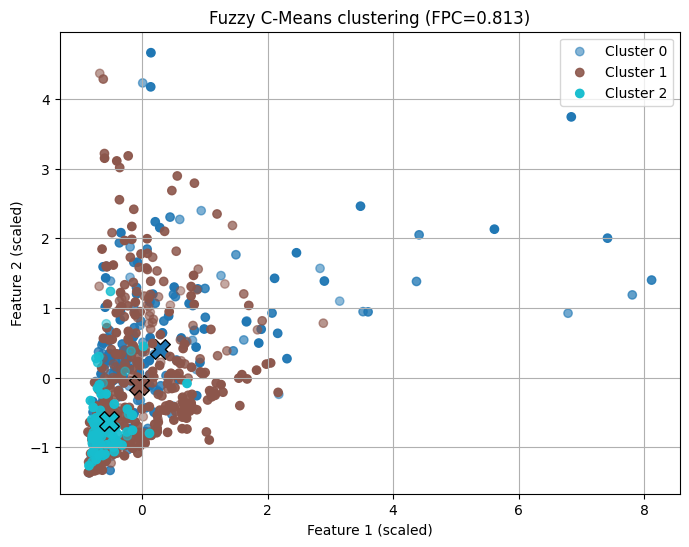

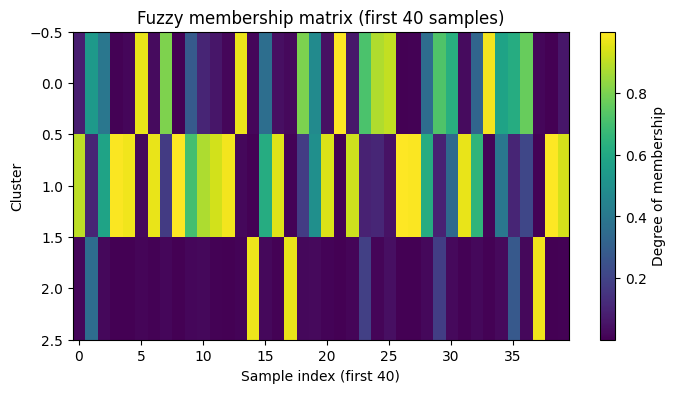

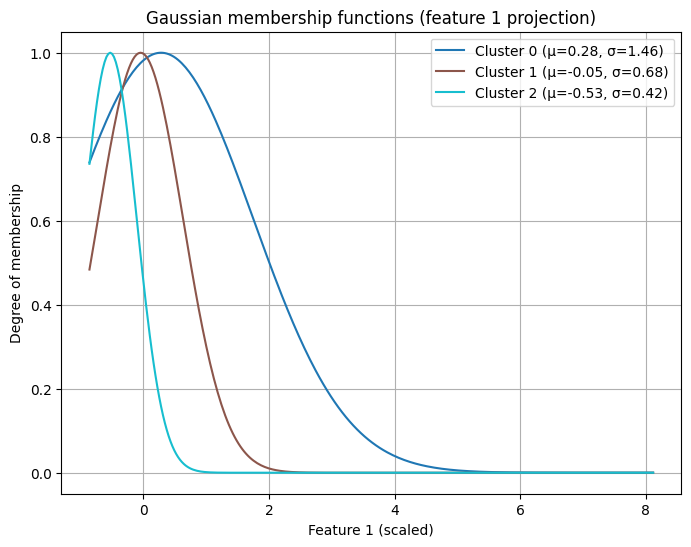

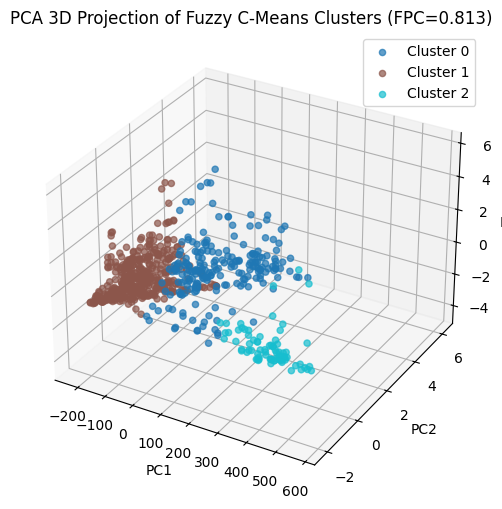

In [6]:
def global_firing_strengths(X, centers, sigmas, agg_prob=False):
    """
    X: (N, D) já escalado e selecionado (top_idx)
    centers,sigmas: (R, D) vindos do FCM global (sem a coluna de y)
    """
    X_t = torch.as_tensor(X, dtype=torch.float32)
    C   = torch.as_tensor(centers, dtype=torch.float32)
    S   = torch.as_tensor(sigmas,  dtype=torch.float32)

    # (N, R, D)
    diff = torch.abs((X_t.unsqueeze(1) - C.unsqueeze(0)) / (S.unsqueeze(0) + 1e-6))

    if agg_prob:
        dist = torch.norm(diff, dim=-1)      # (N, R)  — “probabilística”
    else:
        dist = torch.max(diff, dim=-1).values  # (N, R) — aproxima t-norm min

    W = torch.exp(-0.5 * dist**2)            # (N, R)
    Wn = W / (W.sum(dim=1, keepdim=True) + 1e-9)
    return Wn.numpy(), W.numpy()

centers_global, sigmas_global = fcm_global_init(X_train_s, y_train, n_rules=N_RULES, m=M_FCM, seed=0)
# Para o ANFIS, só usamos as dimensões de entrada (exclui y)
centers_inp = centers_global[:, :-1]
sigmas_inp  = sigmas_global[:, :-1]

In [7]:
# ---------------------------------------------------------
# 3) TS-0 and TS-1 (consequents fechados; premissas fixas)
# ---------------------------------------------------------
def ts0_fit_predict_global(Xtr, ytr, Xte, centers, sigmas, agg_prob=False):
    # Wn com FCM global
    Wn_tr, _ = global_firing_strengths(Xtr, centers, sigmas, agg_prob=agg_prob)
    Wn_te, _ = global_firing_strengths(Xte, centers, sigmas, agg_prob=agg_prob)

    lam = 1e-6
    A = Wn_tr
    c = np.linalg.lstsq(A.T @ A + lam * np.eye(A.shape[1]), A.T @ ytr, rcond=None)[0]
    return A @ c, Wn_te @ c

def ts1_fit_predict_global(Xtr, ytr, Xte, centers, sigmas, agg_prob=False):
    # Wn com FCM global
    Wn_tr, _ = global_firing_strengths(Xtr, centers, sigmas, agg_prob=agg_prob)
    Wn_te, _ = global_firing_strengths(Xte, centers, sigmas, agg_prob=agg_prob)

    def build_Z(X, Wn):
        N, D = X.shape
        R = Wn.shape[1]
        cols = []
        for r in range(R):
            wr = Wn[:, [r]]
            cols.append(wr * X)   # (N, D)
            cols.append(wr)       # bias por regra
        return np.concatenate(cols, axis=1)  # (N, R*(D+1))

    Ztr = build_Z(Xtr, Wn_tr)
    Zte = build_Z(Xte, Wn_te)

    lam = 1e-2  # ridge mais forte para estabilidade
    A = Ztr
    theta = np.linalg.lstsq(A.T @ A + lam * np.eye(A.shape[1]), A.T @ ytr, rcond=None)[0]
    return Ztr @ theta, Zte @ theta

def rmse(a, b): 
    return math.sqrt(mean_squared_error(a, b))

# Quick val check for TS models
_, yhat_val_ts0 = ts0_fit_predict_global(X_train_s, y_train, X_val_s, centers_inp, sigmas_inp, agg_prob=AGG_PROB)
_, yhat_val_ts1 = ts1_fit_predict_global(X_train_s, y_train, X_val_s, centers_inp, sigmas_inp, agg_prob=AGG_PROB)
print(f"TS-0  RMSE (val): {rmse(y_val, yhat_val_ts0):.4f}")
print(f"TS-1  RMSE (val): {rmse(y_val, yhat_val_ts1):.4f}")



TS-0  RMSE (val): 96.3648
TS-1  RMSE (val): 56.9380


In [8]:
# ===========================================================
# 4) ANFIS TSK com treino híbrido
# ===========================================================
class GaussianMF(nn.Module):
    """
    Antecedentes: funções de pertença Gaussianas por REGRA (global),
    tal como no professor: centros e sigmas por regra e por dimensão.
    """
    def __init__(self, centers, sigmas, agg_prob=False):
        super().__init__()
        # centers/sigmas shape: (n_rules, n_features)
        self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
        self.sigmas  = nn.Parameter(torch.tensor(sigmas,  dtype=torch.float32))
        self.agg_prob = agg_prob

    def forward(self, x):
        # x: (batch, n_features)
        # broadcasting -> (batch, n_rules, n_features)
        diff = torch.abs((x.unsqueeze(1) - self.centers.unsqueeze(0)) / (self.sigmas.unsqueeze(0) + 1e-6))

        # Agregação (prob = norma L2; else = max, equivalente a t-norm min nas Gauss)
        if self.agg_prob:
            dist = torch.norm(diff, dim=-1)   # (batch, n_rules)
        else:
            dist = torch.max(diff, dim=-1).values  # (batch, n_rules)

        return torch.exp(-0.5 * dist ** 2)   # firing strengths (batch, n_rules)

class TSK_Anfis(nn.Module):
    """
    TSK model: y = sum_r ( \bar{w}_r * (a_r^T x + b_r) )
    Consequentes partilhados linearmente (por regra) + bias.
    """
    def __init__(self, n_inputs, n_rules, centers, sigmas, agg_prob=False):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_rules  = n_rules

        # Antecedentes (Gaussian MFs globais)
        self.mfs = GaussianMF(centers, sigmas, agg_prob=agg_prob)

        # Consequentes: matriz (n_inputs+1, n_rules) (coef + bias por regra)
        self.consequents = nn.Parameter(torch.randn(n_inputs + 1, n_rules))

    def forward(self, x):
        # x: (batch, n_inputs)
        batch = x.shape[0]

        # firing strengths por regra
        firing = self.mfs(x)                                # (batch, n_rules)
        norm_f = firing / (firing.sum(dim=1, keepdim=True) + 1e-9)

        # saída linear por regra
        x_aug = torch.cat([x, torch.ones(batch, 1, dtype=x.dtype, device=x.device)], dim=1)  # (batch, n_inputs+1)
        rule_outputs = torch.einsum("bi,ir->br", x_aug, self.consequents)  # (batch, n_rules)

        # combinação ponderada
        y = torch.sum(norm_f * rule_outputs, dim=1, keepdim=True)  # (batch, 1)
        return y, norm_f, rule_outputs

@torch.no_grad()
def train_ls(model: TSK_Anfis, X, y):
    """
    Recalibra os consequentes (a,b) por Mínimos Quadrados dadas as pertenças atuais.
    """
    y = y.reshape(-1, 1)
    y_t = torch.as_tensor(y, dtype=torch.float32, device=X.device)

    y_pred, norm_fs, _ = model(X)
    X_aug = torch.cat([X, torch.ones(X.shape[0], 1, device=X.device)], dim=1)  # (N, D+1)

    # Phi: concatena por regra (norm_fs_r * X_aug)
    # Para cada regra r, colunas de X_aug multiplicadas por norm_fs[:, r]
    # Resultado final: (N, n_rules*(D+1))
    N, R = norm_fs.shape
    Dp1 = X_aug.shape[1]
    Phi = torch.empty((N, R * Dp1), dtype=torch.float32, device=X.device)
    for r in range(R):
        Phi[:, r*Dp1:(r+1)*Dp1] = X_aug * norm_fs[:, r:r+1]

    # theta solve: (Phi^T Phi)^{-1} Phi^T y
    theta = torch.linalg.lstsq(Phi, y_t).solution  # (R*(D+1), 1)
    theta = theta.view(R, Dp1).transpose(0, 1)     # -> (D+1, R)
    model.consequents.data.copy_(theta)

def train_gd(model: TSK_Anfis, X, y, epochs=100, lr=1e-3):
    opt = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for _ in range(epochs):
        opt.zero_grad()
        y_pred, _, _ = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        opt.step()

def train_hybrid_anfis(model: TSK_Anfis, X, y, max_iters=ANFIS_MAX_ITERS, gd_epochs=ANFIS_GD_EPOCHS, lr=ANFIS_LR):
    """
    Treino híbrido clássico (professor): alterna
      A) GD nos antecedentes (consequentes congelados)
      B) LS nos consequentes (antecedentes congelados)
    """
    y = y.reshape(-1, 1)
    y_t = torch.tensor(y, dtype=torch.float32, device=X.device)

    # Passo inicial: LS nos consequentes
    train_ls(model, X, y_t)

    for it in range(max_iters):
        # A) GD em antecedentes (mfs), congela consequentes
        model.consequents.requires_grad = False
        # (As MFs em GaussianMF têm parâmetros traináveis)
        for p in model.mfs.parameters():
            p.requires_grad = True
        train_gd(model, X, y_t, epochs=gd_epochs, lr=lr)

        # B) LS em consequentes, congela antecedentes
        model.consequents.requires_grad = True
        for p in model.mfs.parameters():
            p.requires_grad = False
        train_ls(model, X, y_t)

        # volta a libertar antecedentes p/ próxima iteração
        for p in model.mfs.parameters():
            p.requires_grad = True

# ---- Instancia e treina o ANFIS (TSK) com FCM GLOBAL ----
anfis = TSK_Anfis(
    n_inputs=n_features,
    n_rules=N_RULES,
    centers=centers_inp,
    sigmas=sigmas_inp,
    agg_prob=AGG_PROB
).to(device)

In [9]:
Xtr_t = torch.tensor(X_train_s, dtype=torch.float32, device=device)
ytr_t = torch.tensor(y_train,   dtype=torch.float32, device=device)
Xval_t = torch.tensor(X_val_s,  dtype=torch.float32, device=device)
yval_t = torch.tensor(y_val,    dtype=torch.float32, device=device)

train_hybrid_anfis(anfis, Xtr_t, ytr_t, max_iters=ANFIS_MAX_ITERS, gd_epochs=ANFIS_GD_EPOCHS, lr=ANFIS_LR)

anfis.eval()
with torch.no_grad():
    yhat_val_anfis = anfis(Xval_t)[0].cpu().numpy()

print(f"ANFIS (TSK-hybrid) RMSE (val): {rmse(y_val, yhat_val_anfis):.4f}")


C:\Users\Gonçalo Rosa\AppData\Local\Temp\ipykernel_22896\1664307309.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_t = torch.tensor(y, dtype=torch.float32, device=X.device)


ANFIS (TSK-hybrid) RMSE (val): 13.7995


In [10]:
# --------------------------------------------------------
# 5) Meta-model: stack TS0/TS1/ANFIS predictions -> final
#     (treinado em VAL, avaliado em TEST — sem leakage)
# --------------------------------------------------------
# Base models VAL + TEST
# TS-0 / TS-1 com partição global
_, yhat_val_ts0 = ts0_fit_predict_global(X_train_s, y_train, X_val_s, centers_inp, sigmas_inp, agg_prob=AGG_PROB)
_, yhat_test_ts0 = ts0_fit_predict_global(X_train_s, y_train, X_test_s, centers_inp, sigmas_inp, agg_prob=AGG_PROB)

_, yhat_val_ts1 = ts1_fit_predict_global(X_train_s, y_train, X_val_s, centers_inp, sigmas_inp, agg_prob=AGG_PROB)
_, yhat_test_ts1 = ts1_fit_predict_global(X_train_s, y_train, X_test_s, centers_inp, sigmas_inp, agg_prob=AGG_PROB)


with torch.no_grad():
    yhat_test_anfis = anfis(torch.tensor(X_test_s, dtype=torch.float32, device=device))[0].cpu().numpy()

# Train meta (Ridge) em VAL
from sklearn.linear_model import Ridge
Z_train_meta = np.concatenate([yhat_val_ts0, yhat_val_ts1, yhat_val_anfis], axis=1)
y_train_meta = y_val

# Test meta em TEST
Z_test_meta  = np.concatenate([yhat_test_ts0, yhat_test_ts1, yhat_test_anfis], axis=1)

meta = Ridge(alpha=1.0)
meta.fit(Z_train_meta, y_train_meta)
yhat_test_meta = meta.predict(Z_test_meta).reshape(-1,1)


In [11]:
def predict_calories(features_row_np):
    """
    features_row_np: (D_full,) in the SAME order as df.drop(target_col).
    Applies scaling -> selects top_idx -> uses base models (TS-0, TS-1, ANFIS) -> meta (Ridge).
    """
    x_full = scaler.transform(features_row_np.reshape(1, -1))
    x = x_full[:, top_idx]  # respect feature selection

    # --- TS-0 and TS-1 predictions (global partition) ---
    _, ts0 = ts0_fit_predict_global(X_train_s, y_train, x, centers_inp, sigmas_inp, agg_prob=AGG_PROB)
    _, ts1 = ts1_fit_predict_global(X_train_s, y_train, x, centers_inp, sigmas_inp, agg_prob=AGG_PROB)

    # --- ANFIS prediction ---
    with torch.no_grad():
        anf = anfis(torch.tensor(x, dtype=torch.float32, device=device))[0].cpu().numpy()

    # --- Meta-model prediction (Ridge) ---
    z = np.concatenate([ts0, ts1, anf], axis=1)
    meta_pred = meta.predict(z).reshape(-1,1)

    return {
        "ts0": float(ts0.ravel()[0]),
        "ts1": float(ts1.ravel()[0]),
        "anfis": float(anf.ravel()[0]),
        "meta": float(meta_pred.ravel()[0])
    }

In [12]:
print("\n================= TEST RMSE =================")
print(f"TS-0    : {rmse(y_test, yhat_test_ts0):.4f}")
print(f"TS-1    : {rmse(y_test, yhat_test_ts1):.4f}")
print(f"ANFIS   : {rmse(y_test, yhat_test_anfis):.4f}")
print(f"Meta(R) : {rmse(y_test, yhat_test_meta):.4f}")



================= TEST RMSE =================
TS-0    : 76.0776
TS-1    : 16.0212
ANFIS   : 10.6635
Meta(R) : 10.9494


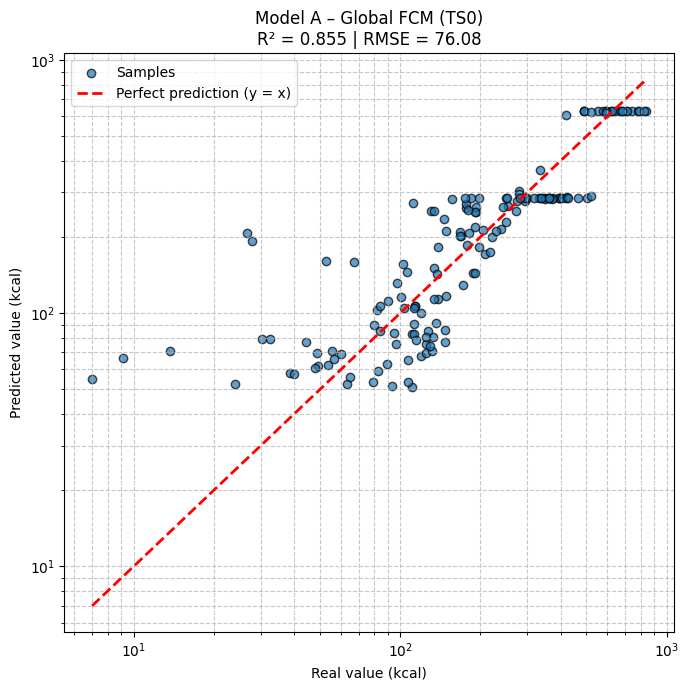

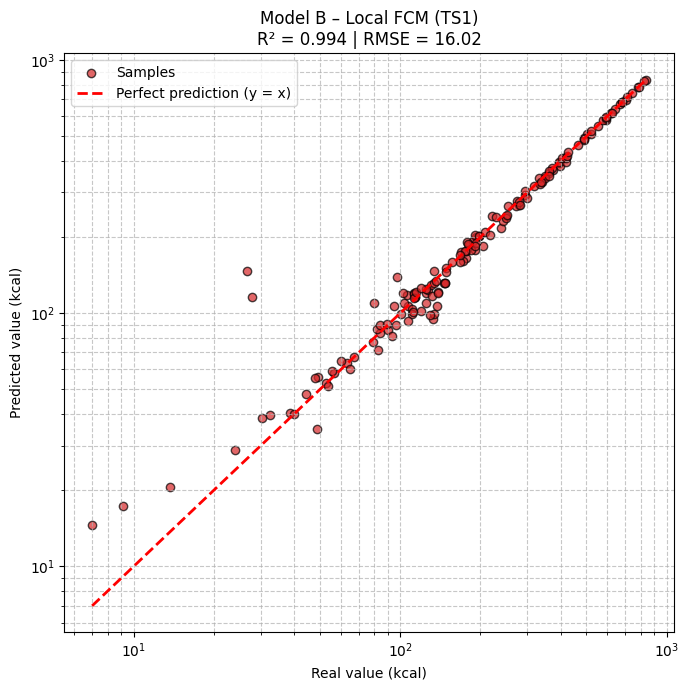

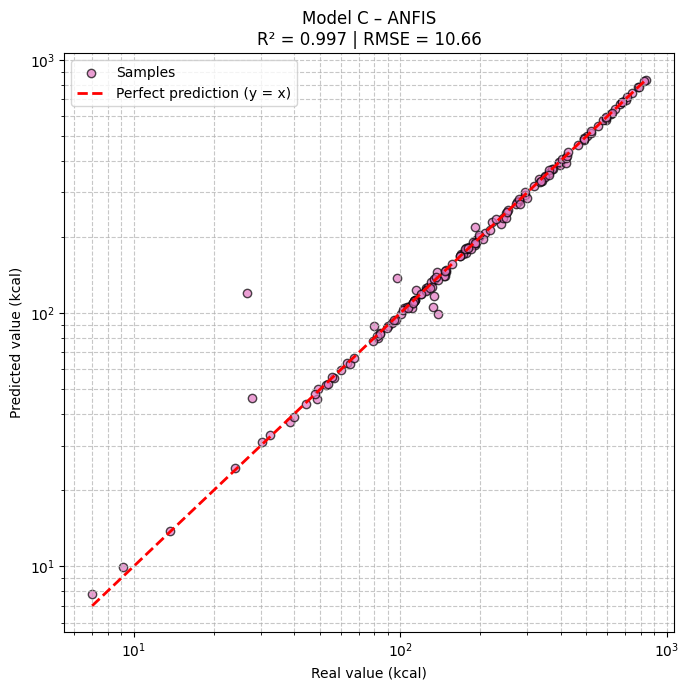

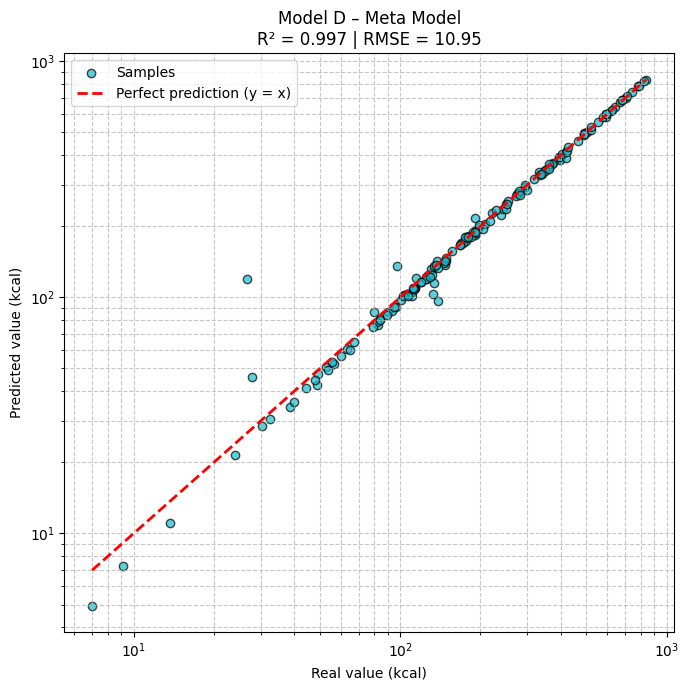

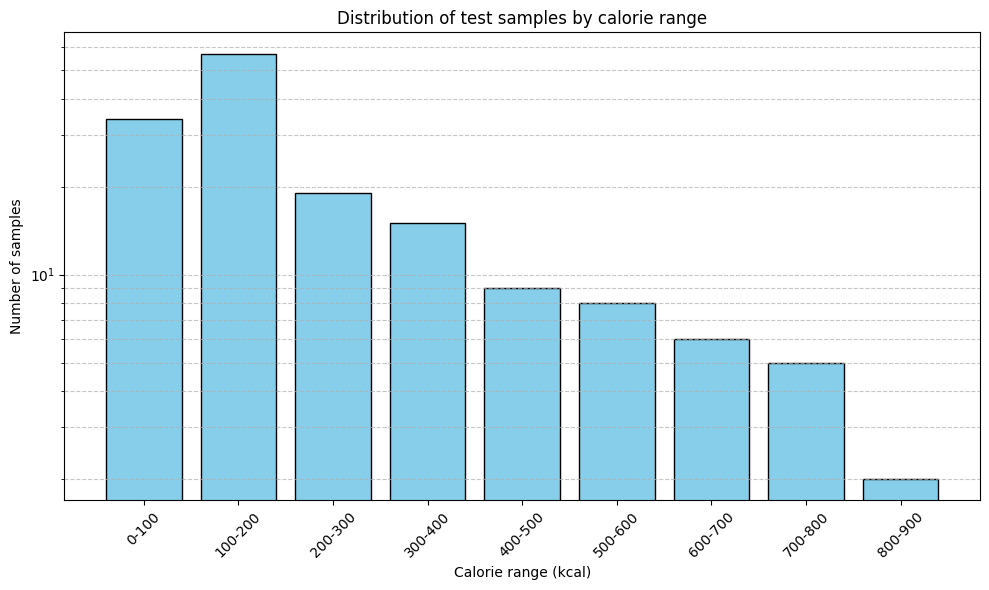

In [13]:
# ===========================================================
# 🔹 Real vs Predicted plots (4 separate figures) – Log scale
# ===========================================================
import matplotlib.pyplot as plt
import numpy as np

def plot_real_vs_pred(y_true, y_pred, model_name, color):
    """
    Creates a scatter plot comparing real and predicted values,
    with a perfect prediction line (y = x) as reference.
    Uses logarithmic scales on both axes.
    """
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    plt.figure(figsize=(7,7))
    plt.scatter(y_true, y_pred, alpha=0.7, edgecolors='k', color=color, label='Samples')
    plt.plot([min(y_true), max(y_true)],
             [min(y_true), max(y_true)],
             'r--', lw=2, label='Perfect prediction (y = x)')

    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    r2 = 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)

    plt.title(f'{model_name}\nR² = {r2:.3f} | RMSE = {rmse:.2f}', fontsize=12)
    plt.xlabel('Real value (kcal)')
    plt.ylabel('Predicted value (kcal)')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


# Colors for consistency
colors = plt.cm.tab10(np.linspace(0, 1, 4))

# --- Model A: Global FCM (TS0)
plot_real_vs_pred(y_test, yhat_test_ts0, "Model A – Global FCM (TS0)", colors[0])

# --- Model B: Local FCM (TS1)
plot_real_vs_pred(y_test, yhat_test_ts1, "Model B – Local FCM (TS1)", colors[1])

# --- Model C: ANFIS
plot_real_vs_pred(y_test, yhat_test_anfis, "Model C – ANFIS", colors[2])

# --- Model D: Meta Model
plot_real_vs_pred(y_test, yhat_test_meta, "Model D – Meta Model", colors[3])


# ===========================================================
# 🔹 Bar chart: Distribution of test samples by calorie range
# ===========================================================
y_true = y_test.flatten()
bins = np.arange(0, np.ceil(y_true.max() / 100) * 100 + 100, 100)
counts, _ = np.histogram(y_true, bins=bins)
bin_labels = [f"{int(bins[i])}-{int(bins[i+1])}" for i in range(len(bins)-1)]

plt.figure(figsize=(10,6))
plt.bar(bin_labels, counts, color='skyblue', edgecolor='black')
plt.xlabel('Calorie range (kcal)')
plt.ylabel('Number of samples')
plt.title('Distribution of test samples by calorie range')
plt.xticks(rotation=45)
plt.yscale('log')  # 🔹 log scale on Y-axis
plt.grid(axis='y', which="both", linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
